In [14]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

import tensorflow_datasets as tfds

In [15]:
# Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Uni\Kandidat\Anvendt maskinlæring\Exam\Data\patch_camelyon'

# Load PatchCamelyon dataset using TFDS
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [16]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = data_dir,
                        download=False,
                        shuffle_files=True)

In [17]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

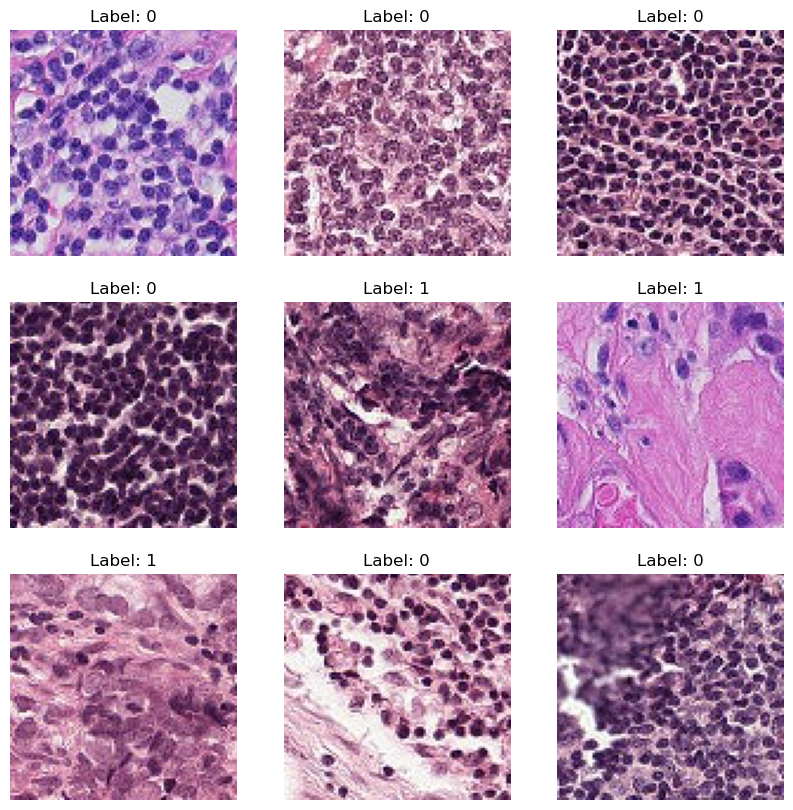

In [19]:
# Take 9 samples from the training set for visualization
samples = list(ds1.take(9))

# Display a 3x3 grid of images
plt.figure(figsize=(10, 10))
for i, sample in enumerate(samples):
    image, label = sample['image'], sample['label']
    image_array = image.numpy()

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_array)
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

plt.show()

In [ ]:
def first_ccn_model():
    input_img = Input(shape=(96,96,3))
    
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset,
                 validation_data=validation_dataset,
                 epochs=2)

In [25]:
input_shape = (96,96,3)

**Problem 1:** 

During the semester you have become very excited about working on the PatchCamelyon (PCam) 
data. Like Veeling et al (2018), you are primarily interested in developing machine learning models that, based on patches of whole-slide images of lymph node sections, can assist pathologists in 
tumor detection.  

The primary objective of this exam is to perform image classification on the PCam dataset, with a 
focus on using autoencoders for image compression.  As a reminder, the PCAM dataset consists of 327,680 color images (96x96pxs) extracted from 
histopathologic scans of lymph node sections. Each image is annotated with a binary label 
indicating presence of metastatic tissue. Specifically, the dataset is divided into 262,144 training 
images, 32,768 validation images, and 32,768 test images. You must use the training/validation 
images to train/validate models that perform well at classifying the test images. Importantly, you are not required to use the full dataset. Use the amount of data that is feasible for you and your hardware configuration.

The PCam dataset is available from many online sources but 
some of them are very slow. Therefore, I recommend accessing the dataset from my SDU 
repository: Link to PCAM. Further instructions and hints on how to load the data efficiently and flexibly by using the module tfds|Tensorflow Dataset are available on the course site’s itslearning platform.

Questions:

You wish to perform image classification. However, you are a little concerned about the size of the 
PCAM images. Their size might be too demanding for your hardware configuration, potentially 
hindering proper hyperparameter tuning and downstream model evaluation. Hence, you wish as a 
pre-processing step to compress the images by using autoencoders (both AEs and VAEs).

1. Discuss how you can use autoencoders to compress images. Motivate why you think 
compressing the images by using AE/VAE will work here and will be better than just simple 
resizing for example by using the function:  

**Initial AE**

In [20]:
# Encoder
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(96, 96, 3)),  # Flatten the image to a vector
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),  # Bottleneck layer
], name='encoder')

# Decoder
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(5,)),  # Decoder takes the bottleneck layer as input
    tf.keras.layers.Dense(96 * 96 * 3, activation='sigmoid'),  # Output layer, sigmoid for image reconstruction
    tf.keras.layers.Reshape((96, 96, 3)),  # Reshape back to image shape
], name='decoder')

# Autoencoder
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')


In [21]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 27648)             0         
                                                                 
 dense_2 (Dense)             (None, 30)                829470    
                                                                 
 dense_3 (Dense)             (None, 5)                 155       
                                                                 
Total params: 829,625
Trainable params: 829,625
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                180       
                                                                 
 dense_5 (Dense)             (None, 

In [104]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [106]:
# Normalize and preprocess the images
def preprocess(example):
    image, label = example['image'], example['label']
    # Normalize pixel values to the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image as both input and target for autoencoder

# Apply preprocessing and batching to the dataset
batch_size = 32
dataset_processed = dataset_10_percent.map(preprocess).batch(batch_size)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Train the autoencoder on the PatchCamelyon dataset
autoencoder.fit(X_train, y_train, epochs=5)

Sample Variational Autoencoder

In [53]:
latent_dim = 2
v_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, 2, activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
v_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, 1, padding='same'),
])

In [55]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    # Output from encoder
    mean, logvar = model.encode(x)    
    # The reparameterization trick
    z = model.reparameterize(mean, logvar)    
    # We assume that p(x|z) is multivariate Bernoulli, ie. the final dense layer 
    # has a sigmoid activation function, see page. 11
    # in Kingma, D. P., & Welling, M. (2013).
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, 
                                                        labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])    
    # Assume normaility of p(z)
    logpz = log_normal_pdf(z, 0., 0.)    
    # Assume normality of q(z|x)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # -tf.reduce_mean(decoder + sampler - encoder)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [56]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = v_encoder
        self.decoder = v_decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean #sigma= sqrt(exp(logvar))
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [57]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [58]:
for epoch in range(10):
    for train_x in dataset_10_percent:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound:
           {variational_lower_bound}')
    generate_and_save_images(model, epoch, test_sample)

SyntaxError: unterminated string literal (detected at line 10) (3815896794.py, line 10)